# PanArctic DSL - Download Copernicus Marine data

Pierre Priou 2022-03-03

## Packages loading

The Copernicus Marine Environment Monitoring Service (CMEMS) requires `motuclient` for downloading data. Here, I download monthly physical data—temperature, salinity, and current velocities—from the Hybrid Coordinate Ocean Model (HYCOM) over several depth (0, 222, 380, 644, 1062 m depth). For help downloading data check the [Copernicus help](https://help.marine.copernicus.eu/en/articles/5211063-how-to-use-the-motuclient-within-python-environment-e-g-spyder).

In [1]:
import os
import getpass
import motuclient
import datetime as dt
import pandas as pd
import xarray as xr # For reading NetCDF files

Define functions used for downloading CMEMS data.

In [2]:
# Define MotuOptions class
class MotuOptions:
    def __init__(self, attrs: dict):
        super(MotuOptions, self).__setattr__("attrs", attrs)

    def __setattr__(self, k, v):
        self.attrs[k] = v

    def __getattr__(self, k):
        try:
            return self.attrs[k]
        except KeyError:
            return None

In [3]:
# Define motu_option_parser
def motu_option_parser(script_template, usr, pwd, output_directory):
    dictionary = dict(
        [e.strip().partition(" ")[::2] for e in script_template.split('--')])
    dictionary['variable'] = [value for (var, value) in [e.strip().partition(" ")[::2] for e in script_template.split('--')] if var == 'variable']  # pylint: disable=line-too-long
    for k, v in list(dictionary.items()):
        if v == '<OUTPUT_DIRECTORY>':
            dictionary[k] = output_directory
        #if v == '<OUTPUT_FILENAME>':
        #    dictionary[k] = output_filename
        if v == '<USERNAME>':
            dictionary[k] = usr
        if v == '<PASSWORD>':
            dictionary[k] = pwd
        if k in ['longitude-min', 'longitude-max', 'latitude-min', 
                 'latitude-max', 'depth-min', 'depth-max']:
            dictionary[k] = float(v)
        if k in ['date-min', 'date-max']:
            dictionary[k] = v[1:-1]
        dictionary[k.replace('-','_')] = dictionary.pop(k)
    dictionary.pop('python')
    dictionary['auth_mode'] = 'cas'
    return dictionary

Load credentials.

In [4]:
USERNAME = input('Enter your username: ')
PASSWORD = getpass.getpass('Enter your password: ')

Enter your username: ppriou
Enter your password: ········


Define the geographical area and timeseries subset that I want to download. Data is averaged on the 15th of every month.

In [5]:
# Area definition
lon_min = -160
lon_max = 40
lat_min = 60
lat_max = 85

# Date definitions
date_start = dt.datetime(2014, 12, 15)
date_end = dt.datetime(2017, 12, 15)
daterange = pd.date_range(date_start, date_end, freq = "MS") + pd.DateOffset(days=14)

Set output directory.

In [3]:
OUTPUT_DIRECTORY = 'data/remote_sensing/physics'

## Download data

Setup the `motuclient` template command line. The request for the ARCTIC_MULTIYEAR_PHY_002_003-TDS dataset is retrieved from the Copernicus website ([more info here](https://help.marine.copernicus.eu/en/articles/4899195-how-to-generate-and-run-a-script-to-download-a-subset-of-a-dataset-from-the-copernicus-marine-data-store#h_dee5a134b1)) and pasted below.

In [7]:
# Depths of interest
depth = [0, 222, 380, 644, 1062]

Setup the for loop to download data.

In [9]:
for z in depth:
    for date in daterange:
        request_tmp = 'python -m motuclient \
        --motu https://my.cmems-du.eu/motu-web/Motu \
        --service-id ARCTIC_MULTIYEAR_PHY_002_003-TDS \
        --product-id cmems_mod_arc_phy_my_topaz4_P1M \
        --longitude-min '+ str(lon_min) +' \
        --longitude-max '+ str(lon_max) +' \
        --latitude-min '+ str(lat_min) +' \
        --latitude-max '+ str(lat_max) +' \
        --date-min "'+ str(date) +'" \
        --date-max "'+ str(date) +'" \
        --depth-min '+ str(z) +' \
        --depth-max '+ str(z) +' \
        --variable latitude --variable longitude --variable so --variable thetao --variable vxo --variable vyo \
        --out-dir <OUTPUT_DIRECTORY> \
        --out-name '+ str(date.year) + str(f"{date:%m}") + str(f"{date:%d}") + "_" + str(z) + "m_phy_CMEMS.nc" +' \
        --user <USERNAME> --pwd <PASSWORD>'
        print("Downloading " + str(date.year) + "-" + str(f"{date:%m}") + "-" + str(f"{date:%d}") + " " + str(z) + " m")
        # Setup request
        data_request_options_dict_automated = motu_option_parser(request_tmp, USERNAME, PASSWORD, OUTPUT_DIRECTORY)
        # Download requested data
        motuclient.motu_api.execute_request(MotuOptions(data_request_options_dict_automated))
        if date == daterange[-1]:
            print("Download finished.")

Download finished.


Data is downloaded as NetCDF. I then combine them and analyzed them in R.

## Data check

Open, read, and plot the NetCDF I just downloaded to check whether it worked or not.

In [5]:
# Open and read a file
DS = xr.open_dataset(OUTPUT_DIRECTORY + "/20150215_380m_phy_CMEMS.nc")
print(DS)

<xarray.Dataset>
Dimensions:        (depth: 1, time: 1, x: 546, y: 389)
Coordinates:
  * depth          (depth) float32 380.0
    latitude       (y, x) float32 ...
  * x              (x) float32 -34.125 -34.0 -33.875 ... 33.75 33.875 34.0
  * y              (y) float32 -34.125 -34.0 -33.875 ... 14.125 14.25 14.375
  * time           (time) datetime64[ns] 2015-02-15
    longitude      (y, x) float32 ...
Data variables:
    stereographic  int32 ...
    thetao         (time, depth, y, x) float32 ...
    so             (time, depth, y, x) float32 ...
    vxo            (time, depth, y, x) float32 ...
    vyo            (time, depth, y, x) float32 ...
Attributes:
    institution:                     NERSC, Thormoehlens gate 47, N-5006 Berg...
    history:                         20211013:Created by program hyc2proj, ve...
    source:                          NERSC-HYCOM model fields
    references:                      http://topaz.nersc.no
    FROM_ORIGINAL_FILE__field_type:  Files based o

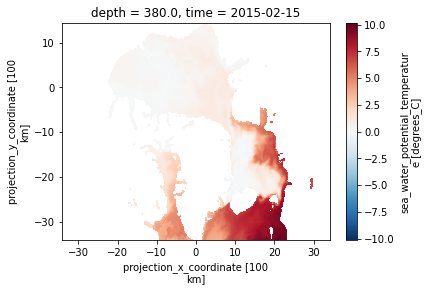

In [9]:
# Plot map of potential temperature at 380 m for Feburary 2015
DS.thetao.sel().plot()